# Using Random Forests to explore feature importances
- [Based on the post here](https://explained.ai/rf-importance/index.html)
- [rfpimp package](https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py#L263)
- [sklearn commit implementing Permutation Importance](https://github.com/scikit-learn/scikit-learn/pull/13146)
- []()
NOTE: OOB = out-of-bag

In [2]:
from pathlib import Path
import os
import warnings
from collections import namedtuple

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [4]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [5]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'one_month_forecast'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'
# TARGET_VAR =      'VCI3M'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [10]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [11]:
y_train

<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 166)
Coordinates:
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat       (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * time      (time) datetime64[ns] 2002-03-31 2002-04-30 ... 2015-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 81.67 51.61 69.27 ... 80.3 86.43 88.95

In [7]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

12

In [8]:
dynamic_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

static_vars_to_include = [
    v
    for v in static_ds.data_vars
    if all([ign_v not in v for ign_v in ealstm.ignore_vars])
]
static = static_ds[static_vars_to_include]

In [9]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

### Check the static data

In [10]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
print(f"N Vars: {len(list(static_data.data_vars))}")
static_data

N Vars: 23


<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lat                                         (lat) float32 -5.0 -4.75 ... 6.0
  * lon                                         (lon) float32 33.75 ... 42.25
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    t2m_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    t2m_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

# Using rfpimp

In [6]:
from rfpimp import (
    importances, 
    plot_importances, 
    plot_corr_heatmap, 
    feature_corr_matrix, 
    feature_dependence_matrix,
    plot_dependence_heatmap
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [12]:
vars_to_include = [
    'boku_VCI',
#     'VCI3M',
#     'VCI',
    'precip',
#     'E',
#     'Eb',
#     'SMroot',
    'SMsurf',
#     'p84.162',
    'pev',
#     'sp',
#     't2m',
#     'tp',
#     'modis_ndvi',
]


# join into one dataframe
ytrain_df = y_train.to_dataframe()
train_index = ytrain_df.index
xtrain_df = (ds[vars_to_include].sel(time=y_train.time)).to_dataframe()  # dynamic_ds  ds
xtrain_df = xtrain_df.shift(1)
xtrain_df.index = train_index

ytest_df = y_test.to_dataframe()
test_index = ytest_df.index
xtest_df = (ds[vars_to_include].sel(time=y_test.time)).to_dataframe()  # dynamic_ds  ds
xtest_df = xtest_df.shift(1)
xtest_df.index = test_index

In [13]:
train_df = ytrain_df.rename(columns={TARGET_VAR: "y"}).join(xtrain_df).dropna(how='any')
df_train = train_df.reset_index().drop(columns=["lat", "lon", "time"])

valid_df = ytest_df.rename(columns={TARGET_VAR: "y"}).join(xtest_df).dropna(how='any')
df_val = valid_df.reset_index().drop(columns=["lat", "lon", "time"])

In [14]:
print(
    "Vars to include:",
    [c for c in df_train.columns if c != "y"]
)

Vars to include: ['boku_VCI', 'precip', 'SMsurf', 'pev']


In [15]:
display(df_val.head())
display(df_train.head())

,y,boku_VCI,precip,SMsurf,pev
0,77.118227,74.480022,5.388689,0.400904,-0.004383
1,67.857143,77.118227,4.864708,0.405087,-0.005492
2,55.175545,67.857143,4.980642,0.374915,-0.006534
3,68.439809,55.175545,4.813388,0.380187,-0.004900
4,46.759907,68.439809,2.586428,0.313680,-0.006784


,y,boku_VCI,precip,SMsurf,pev
0,84.564165,81.666667,5.105174,0.376966,-0.005411
1,50.743155,84.564165,4.311175,0.315649,-0.006567
2,48.158508,50.743155,3.746876,0.340250,-0.006228
3,25.182863,48.158508,-0.455273,0.262561,-0.006920
4,23.965517,25.182863,-3.039095,0.226608,-0.006850


In [ ]:
rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_leaf=5,
    n_jobs=-1,
    oob_score=True
)

rf.fit(df_train.drop(columns='y'), df_train['y'])

In [ ]:
rf_pred = pd.DataFrame({"y": df_val['y'], "pred": rf.predict(df_val.drop(columns='y'))})
rf_pred.index = valid_df.index
rf_pred.head(3)

In [ ]:
from src.analysis import spatial_r2, spatial_rmse

rf_preds = rf_pred.to_xarray().transpose("time", "lat", "lon")
rf_r2 = spatial_r2(rf_preds['y'], rf_preds['pred'])
rf_rmse = spatial_rmse(rf_preds['y'], rf_preds['pred'])

print(f"R2: {rf_r2.mean().values:.2f}")
print(f"RMSE: {rf_rmse.mean().values:.2f}")

In [ ]:
### Choose the pixel number to visualise
i = 10

pixel = y_train.stack(pixel=['lat', 'lon']).isel(pixel=i).pixel.values.reshape(-1)[0]
lat = pixel[0]
lon = pixel[1]

fig, ax = plt.subplots()
rf_pred.query(f"lat == {lat} & lon == {lon}").plot(ax=ax)

ax.set_xticklabels([d._date_repr for d in rf_pred.reset_index()['time']], rotation=70)
ax.set_xlabel("time");

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### DEFAULT importance scores

In [ ]:
def plot_the_default_importances(rf, X):
    """ Standard gini importance scores from Sklearn
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    """
    importances = rf.feature_importances_
    assert len(importances) == len(df_train.drop(columns='y').columns), f"{len(importances)} features Got: {df_train.drop(columns='y').columns}"
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    return plt.gca()

In [ ]:
ax = plot_the_default_importances(rf, X=df_val.drop(columns='y'))
ax.set_xticklabels(df_val.drop(columns='y').columns);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### rfpimp importances

In [ ]:
imp = importances(rf, df_val.drop(columns='y'), df_val['y'])
viz = plot_importances(imp)
viz

### colinearities?

In [ ]:
plot_corr_heatmap(df_train)

# plot these dependencies
Essentially, we're looking for columns with multiple entries close to 1.0 as those are the features that predict multiple other features

In [ ]:
df_train.head()

In [48]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(df_train.drop(columns=["y"]), sort_by_dependence=True)

In [49]:
D['Dependence'].sort_values(ascending=False)

SMsurf        0.55
pev          0.287
precip       0.255
boku_VCI    0.0139
Name: Dependence, dtype: object

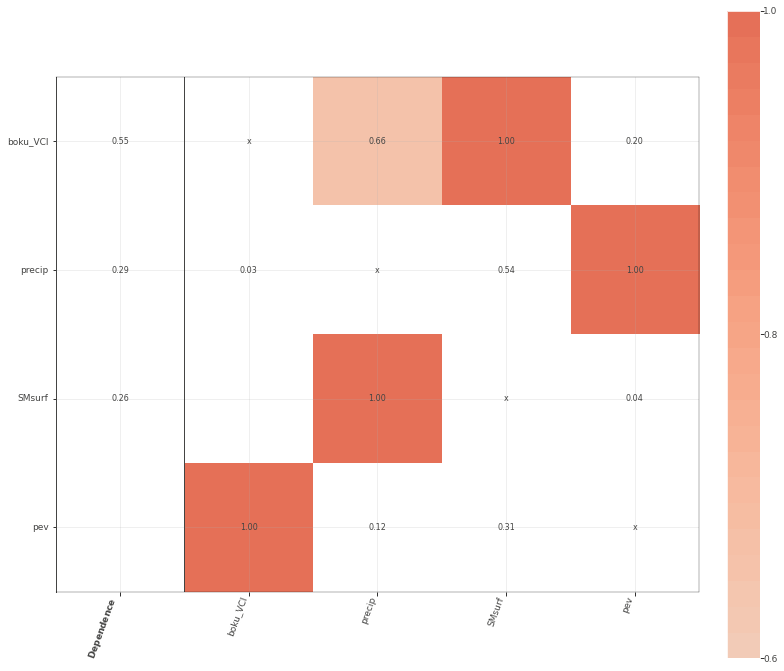

In [50]:
viz = plot_dependence_heatmap(D, figsize=(11,10))

# What about autoregressive models
- https://tsfresh.readthedocs.io/en/latest/text/data_formats.html#data-formats-label

In [35]:
import tsfresh

from tsfresh.utilities.dataframe_functions import roll_time_series
from sklearn import preprocessing

In [46]:
# scaler = preprocessing.scale(df_train)

In [47]:
df_train.head()

,y,boku_VCI,precip,SMsurf,pev
0,84.564165,81.666667,5.105174,0.376966,-0.005411
1,50.743155,84.564165,4.311175,0.315649,-0.006567
2,48.158508,50.743155,3.746876,0.340250,-0.006228
3,25.182863,48.158508,-0.455273,0.262561,-0.006920
4,23.965517,25.182863,-3.039095,0.226608,-0.006850


In [18]:
train_df.head()

y   boku_VCI    precip    SMsurf       pev
lat  lon   time                                                          
-5.0 33.75 2002-04-30  84.564165  81.666667  5.105174  0.376966 -0.005411
           2002-05-31  50.743155  84.564165  4.311175  0.315649 -0.006567
           2002-06-30  48.158508  50.743155  3.746876  0.340250 -0.006228
           2002-07-31  25.182863  48.158508 -0.455273  0.262561 -0.006920
           2002-08-31  23.965517  25.182863 -3.039095  0.226608 -0.006850

In [349]:
df = train_df.reset_index()
pixel_id, pixel_label = pd.factorize(df['lat'].astype(str) + ', ' + df['lon'].astype(str))
df['pixel_id'] = pixel_id
df = df.drop(columns=["lat", "lon"])

# how to create the kind variable?
ts_df = (
    df.set_index(['time', 'pixel_id'])
    .stack().reset_index()
    .rename(columns={"level_2": "kind", 0: "value"})
)

# ts_df = ts_df[['pixel_id', 'time', 'kind', 'value']]
# (column_id="pixel_id", column_sort="time", column_kind="kind", column_value="value")

print(ts_df.shape)
ts_df.head()

(1165185, 4)


,time,pixel_id,kind,value
0,2002-04-30,0,y,84.564
1,2002-04-30,0,boku_VCI,81.667
2,2002-04-30,0,precip,5.105
3,2002-04-30,0,SMsurf,0.377
4,2002-04-30,0,pev,-0.005


In [353]:
# ts_df.eval(f"pixel_id in {np.arange(100)}")
ts_df = ts_df.loc[[pid in np.arange(10) for pid in ts_df['pixel_id']]]
print(ts_df.shape)
ts_df.head()

(8295, 4)


,time,pixel_id,kind,value
0,2002-04-30,0,y,84.564
1,2002-04-30,0,boku_VCI,81.667
2,2002-04-30,0,precip,5.105
3,2002-04-30,0,SMsurf,0.377
4,2002-04-30,0,pev,-0.005


In [354]:
data = ts_df
data.head()

,time,pixel_id,kind,value
0,2002-04-30,0,y,84.564
1,2002-04-30,0,boku_VCI,81.667
2,2002-04-30,0,precip,5.105
3,2002-04-30,0,SMsurf,0.377
4,2002-04-30,0,pev,-0.005


In [375]:
# NOTE: no idea what this function does ...

d = roll_time_series(
    data, 
    column_id="pixel_id", 
    column_sort="time", 
    column_kind="kind", 
#     column_value="value",
    rolling_direction=1,
    max_timeshift=3,
)

(d['time'] == d['pixel_id']).mean()

0.2522810218978102

In [374]:
d['table'] = (d['time'] != d['pixel_id']).cumsum()
d.loc[(d['table'] == 0 )& (d['kind'] == 'y')]

,time,value,pixel_id,kind,new_time,table
24589,2002-03-31,46.573,2002-03-31,y,False,0
24594,2002-03-31,69.446,2002-03-31,y,False,0
24599,2002-03-31,70.327,2002-03-31,y,False,0
24604,2002-03-31,95.206,2002-03-31,y,False,0
24609,2002-03-31,69.273,2002-03-31,y,False,0
24614,2002-03-31,46.569,2002-03-31,y,False,0
24615,2002-03-31,51.612,2002-03-31,y,False,0
24620,2002-03-31,82.846,2002-03-31,y,False,0
24626,2002-03-31,57.357,2002-03-31,y,False,0


In [371]:
ts_df.loc[ts_df['pixel_id'] == 0]

,time,pixel_id,kind,value
0,2002-04-30,0,y,84.564
1,2002-04-30,0,boku_VCI,81.667
2,2002-04-30,0,precip,5.105
3,2002-04-30,0,SMsurf,0.377
4,2002-04-30,0,pev,-0.005
...,...,...,...,...
820,2015-12-31,0,y,60.119
821,2015-12-31,0,boku_VCI,28.233
822,2015-12-31,0,precip,4.488
823,2015-12-31,0,SMsurf,0.327


In [ ]:
def minus_timesteps(
    time: pd.Timestamp, time_delta: int, freq: str = "M"
) -> pd.Timestamp:
    """
    alternative method:
    ```
        # create ordered list of timesteps
        min_time='1980-01'; max_time='2020-01'
        date_range = pd.date_range(min_time, max_time, freq=freq)
    ```
    """
    # create timedelta object
    tdelta = pd.Timedelta(time_delta, freq)

    # take the timedelta to get the starting timestep
    minus_time = time - tdelta

    if freq == "M":
        from pandas.tseries.offsets import MonthEnd

        # our pipeline mostly works with 'MS' resampled data
        # so monthly data is always at the END of the month
        minus_time = minus_time + MonthEnd(1)

    return minus_time


X_dataset = self.dynamic_ds.sel(time=slice(min_X_date, max_X_date))
y_dataset = self.dynamic_ds[[target_var]].sel(time=target_time)

# sklearn pipeline
- [skits](https://github.com/EthanRosenthal/skits)
- [skits post](https://www.ethanrosenthal.com/2018/01/28/time-series-for-scikit-learn-people-part1/)
- [tsfresh](https://tsfresh.readthedocs.io/en/latest/text/sklearn_transformers.html)
- [tspreprocess](https://github.com/MaxBenChrist/tspreprocess)

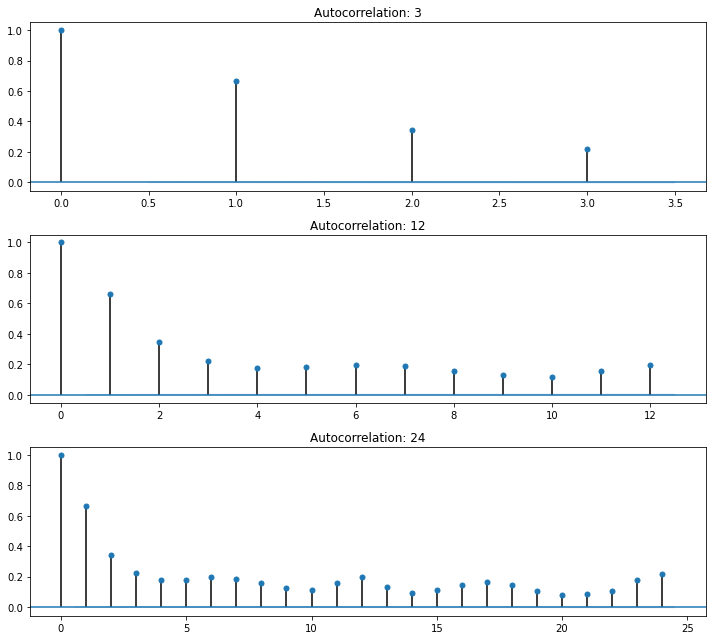

In [241]:
import statsmodels.tsa.api as smt

def plot_multi_acf(data, lags, titles, ylim=None, partial=False):
    """https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/"""
    num_plots = len(lags)
    fig, ax = plt.subplots(len(lags), 1, figsize=(10, 3 * num_plots));
    if num_plots == 1:
        ax = [ax]
    acf_func = smt.graphics.plot_pacf if partial else smt.graphics.plot_acf
    for idx, (lag, title) in enumerate(zip(lags, titles)):
        fig = acf_func(data, lags=lag, ax=ax[idx], title=title);
        if ylim is not None:
            ax[idx].set_ylim(ylim);

    fig.tight_layout();

plot_multi_acf(train_df['y'], lags=[3, 12, 24], titles=[f"Autocorrelation: {i}" for i in [3, 12, 24]])

In [68]:
df = df.set_index('time')
df.head()

,y,boku_VCI,precip,SMsurf,pev,pixel_id
time,,,,,,
2002-04-30,84.564,81.667,5.105,0.377,-0.005,0
2002-05-31,50.743,84.564,4.311,0.316,-0.007,0
2002-06-30,48.159,50.743,3.747,0.340,-0.006,0
2002-07-31,25.183,48.159,-0.455,0.263,-0.007,0
2002-08-31,23.966,25.183,-3.039,0.227,-0.007,0


In [196]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

In [197]:
X = df.drop(columns=["y"])
test_X = X.loc["2013":]
train_X = X.loc[:"2012"]

y = df[["y", "pixel_id"]]
test_y = y.loc["2013":]
train_y = y.loc[:"2012"]

In [213]:
estimators = [
    ("pre_scale", StandardScaler()),
#     ("reduce_dim", PCA()),
    ("model", ElasticNet(normalize=False)),
#     ("model", HistGradientBoostingRegressor(loss='least_squares')),
#     ("model", GradientBoostingRegressor(loss='huber')),
]
pipe = Pipeline(estimators)
param_grid = {
#     "reduce_dim__n_components": [1, 2, 3, 4], 
    "model__l1_ratio": [.1, .5, .7, .9, .95, .99, 1],
    "model__alpha": np.linspace(0.01, 0.3, 5),
#     "model__learning_rate": np.linspace(0.001, 0.5, 5),
#     "model__min_samples_split": np.arange(2, 5),
#     "model__max_iter": np.linspace(100, 200, 2).astype(int),
}

In [214]:
scoring = dict(r2=make_scorer(r2_score), mse=make_scorer(mean_squared_error))
search = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring=scoring, refit='mse')
search.fit(train_X.drop(columns="pixel_id"), train_y.drop(columns="pixel_id"))
pipe = search.best_estimator_

In [215]:
dir(search)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_required_parameters',
 '_run_search',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'refit_time_',
 'return_train_score',
 'score',
 'scorer_',
 'scoring',
 'set_params',
 'transform',
 'verbose']

In [216]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=293.963):
{'model__alpha': 0.3, 'model__l1_ratio': 0.1}


In [217]:
pipe

Pipeline(memory=None,
         steps=[('pre_scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 ElasticNet(alpha=0.3, copy_X=True, fit_intercept=True,
                            l1_ratio=0.1, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [218]:
pipe.fit(train_X.drop(columns="pixel_id"), train_y.drop(columns="pixel_id"))
y_hat = pipe.predict(test_X.drop(columns="pixel_id"))

In [219]:
fit = pd.DataFrame(
    {"yhat":y_hat, "y": test_y['y'], "pixel_id": test_y['pixel_id']}
)
# fit["yhat"] = fit["yhat"].clip(lower=0, upper=100)

In [220]:
print("R2: ", r2_score(fit['y'], fit['yhat']))
print("MSE: ", np.sqrt(mean_squared_error(fit['y'], fit['yhat'])))

R2:  0.4874193563607764
MSE:  16.5326473799353


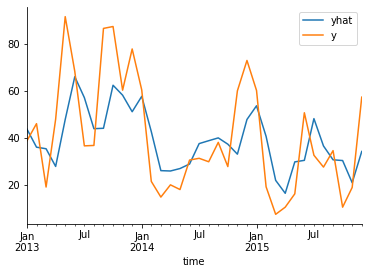

In [221]:
pixel_id = 700
fit.loc[fit['pixel_id'] == pixel_id].drop(columns="pixel_id").plot()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## using skits
- https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/

In [276]:
import statsmodels.tsa.api as smt

def plot_multi_acf(data, lags, titles, ylim=None, partial=False):
    """https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/"""
    num_plots = len(lags)
    fig, ax = plt.subplots(len(lags), 1, figsize=(10, 3 * num_plots));
    if num_plots == 1:
        ax = [ax]
    acf_func = smt.graphics.plot_pacf if partial else smt.graphics.plot_acf
    for idx, (lag, title) in enumerate(zip(lags, titles)):
        fig = acf_func(data, lags=lag, ax=ax[idx], title=title);
        if ylim is not None:
            ax[idx].set_ylim(ylim);

    fig.tight_layout();

In [278]:
from skits.preprocessing import (ReversibleImputer,
                                 DifferenceTransformer)
from skits.pipeline import ForecasterPipeline
from sklearn.preprocessing import StandardScaler

from skits.feature_extraction import (AutoregressiveTransformer,
                                      SeasonalTransformer)
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              RandomForestRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import FeatureUnion


In [269]:
# need a ReversibleImputer in between each differencing operation to handle the Null values

pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=1)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler())
])

x = df['y'].copy()[:, np.newaxis]

In [270]:
Xt = pipeline.fit_transform(x, df['y'])

In [272]:
print(Xt[:5])
print(df['y'].head())

[[-1.59403728e-19]
 [-1.69096790e+00]
 [-1.29226909e-01]
 [-1.14872646e+00]
 [-6.08652292e-02]]
time
2002-04-30    84.564
2002-05-31    50.743
2002-06-30    48.159
2002-07-31    25.183
2002-08-31    23.966
Name: y, dtype: float64


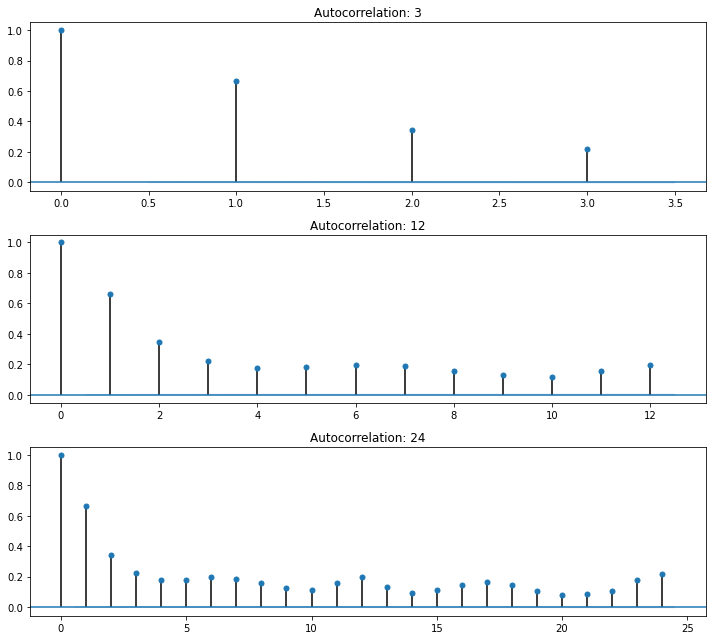

In [277]:
# BEFORE processing
lags = [3, 12, 24]
titles = [f"Autocorrelation: {i}" for i in [3, 12, 24]]

plot_multi_acf(x, lags, titles)

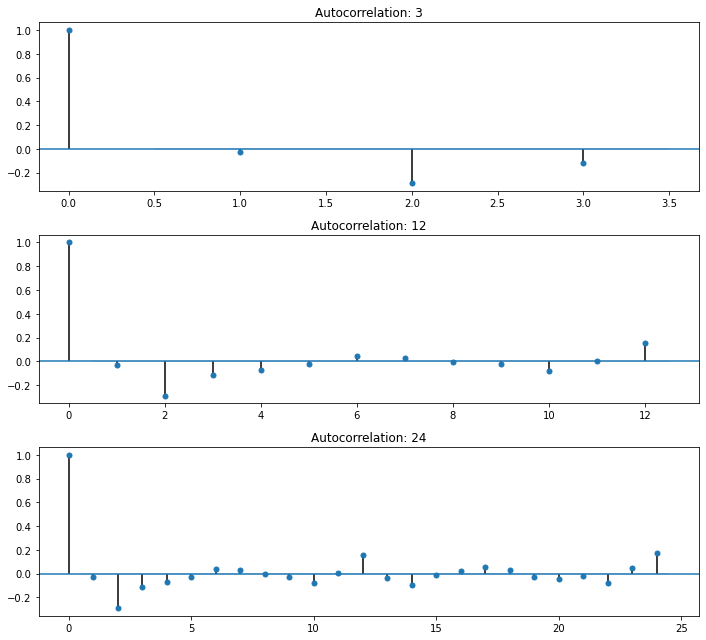

In [275]:
# AFTER processing
plot_multi_acf(Xt.squeeze(), lags, titles)

## fitting a model

In [316]:
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=1)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler()),
#     ('features', FeatureUnion([
#         ('ar_features', AutoregressiveTransformer(num_lags=1)),
#     ])),
#     ('post_feature_imputer', ReversibleImputer()),
#     ('post_feature_scaler', StandardScaler()),
#     ('regressor', LinearRegression(fit_intercept=False))
])

In [317]:
pipeline = pipeline.fit(x, df['y'])
# yhat = pipeline.predict(x, to_scale=True)

print(x[:5])
pipeline.transform(x)[:5]

[[84.56416465]
 [50.74315515]
 [48.15850816]
 [25.18286311]
 [23.96551724]]


array([[-1.59403728e-19],
       [-1.69096790e+00],
       [-1.29226909e-01],
       [-1.14872646e+00],
       [-6.08652292e-02]])

In [308]:
results = pd.DataFrame(dict(y=df['y'], yhat=yhat))

In [309]:
results.head()

,y,yhat
time,,
2002-04-30,84.564,84.564
2002-05-31,50.743,50.743
2002-06-30,48.159,48.159
2002-07-31,25.183,25.183
2002-08-31,23.966,23.966
